Customer churn, or customer attrition, is when an existing customer ends a relationship with a business that provides a service. A variety of companies inclusing Internet service providers, insurance firms, and alarm monitoring services, often use customer churn analysis as a business metric because the cost of retaining an existing customer is far less than acquiring a new one. Companies from these sectors often have customer service branches which attempt to win back defecting clients, because recovered long-term customers can be worth much more to a company than newly recruited clients.

Companies usually make a distinction between voluntary churn and involuntary churn. Voluntary churn occurs due to a decision by the customer to switch to another company or service provider, involuntary churn occurs due to circumstances such as a customer's relocation to a long-term care facility, death, or the relocation to a distant location. In most applications, involuntary reasons for churn are excluded from the analytical models. Analysts tend to concentrate on voluntary churn, because it typically occurs due to factors of the company-customer relationship which companies control, such as how billing interactions are handled or how after-sales help is provided.

Predictive analytics use churn prediction models that predict customer churn by assessing their propensity of risk to churn. Since these models generate a small prioritized list of potential defectors, they are effective at focusing customer retention marketing programs on the subset of the customer base who are most vulnerable to churn.

In this exercise, you will be guided through a simplified customer churn analysis to give you an overview of how machine learning is used to build a model that can predict customer churn for a telcom company.

In [1]:
#Import relevant libraries

import numpy as np # linear algebra
import pandas as pd # data processing
import os
import matplotlib.pyplot as plt #visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns #visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization

In [2]:
#import dataset into pandas data frame and show first 5 rows of the data frame

df = pd.read_csv("Telco-Customer-Churn.csv")
df.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Data preprocessing

Data preprocessing ensures that that there are no missing values or dumplicates in the dataset.

In [3]:
df = df.dropna(how="all") # remove samples with all missing values
df = df[~df.duplicated()] # remove duplicates
total_charges_filter = df.TotalCharges == " "
df = df[~total_charges_filter]
df.TotalCharges = pd.to_numeric(df.TotalCharges)

### Exploratory data analysis

We can start by visualizing our dataset in a correlation matrix.

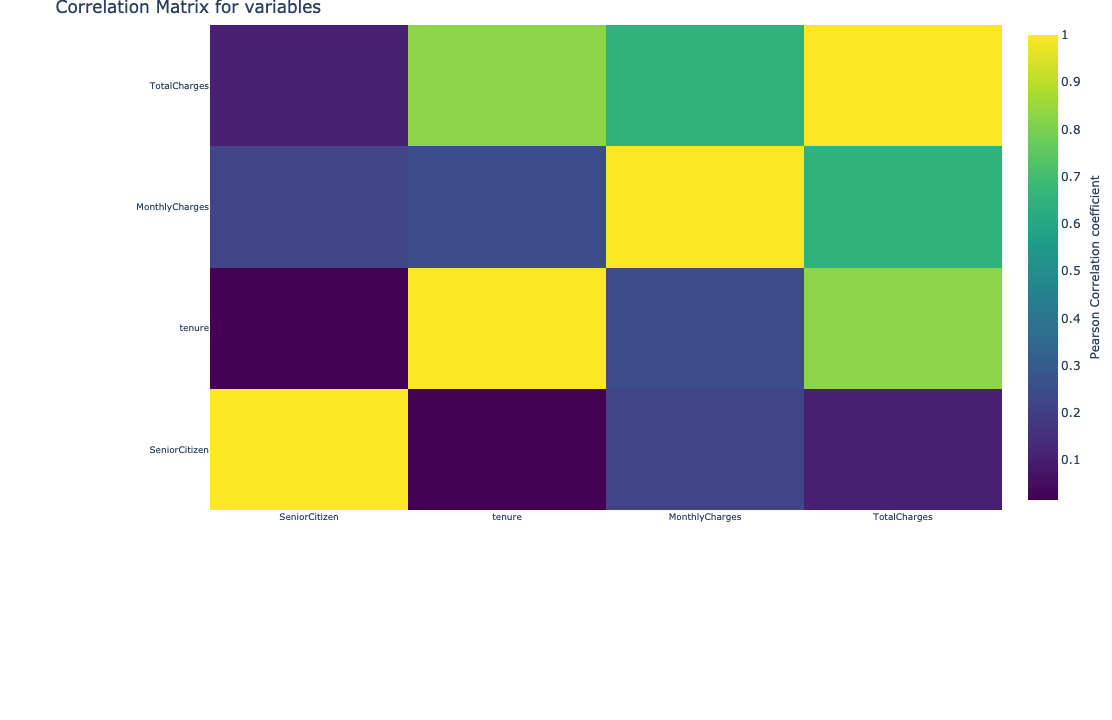

In [4]:
#correlation
correlation = df.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data = [trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

Let's look a bit closer at the variable in our dataset.

In the dataset, we have variables that are categorical (i.e., variables that have values in 2 or more categories) and variables that are numerical. We can combine all the numberical and categorical variables into two groups to understand which variables are associated most with the target variable: customer churn.

Note:\
`tenure` is the number of months a customer has stayed withe the company.\
`MonthlyCharges` is the amount charged to the customer monthly.\
`TotalCharges` is the total amount charged to the customer.

In [5]:
categorical_features = [
 "gender",
 "SeniorCitizen",
 "Partner",
 "Dependents",
 "PhoneService",
 "MultipleLines",
 "InternetService",
 "OnlineSecurity",
 "OnlineBackup",
 "DeviceProtection",
 "TechSupport",
 "StreamingTV",
 "StreamingMovies",
 "Contract",
 "PaperlessBilling!",
 "PaymentMethod",
]
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]

target = "Churn"

In [6]:
df[numerical_features].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


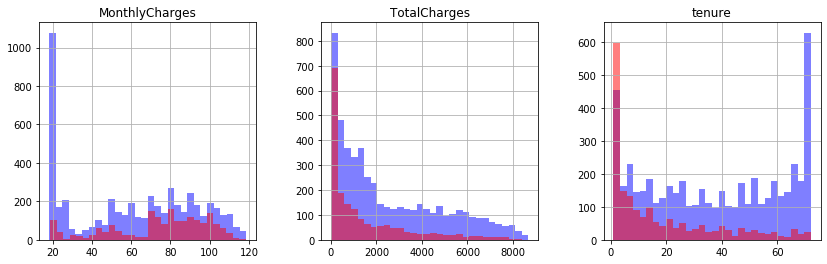

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
hist = df[df.Churn == "No"][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
hist = df[df.Churn == "Yes"][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)

In these histograms, the x axis represents the the numerical variable (MonthlyCharges, TotalCharges, or tenure) and the y axis represents the frequency of churn (red for yes and blue for no). We can see that the greater the TotalCharges and tenure are the less the likelhood of churn.

We can also look at the categorical variables in relation to the target variable. Let's take a look at the the variable `Contract`.

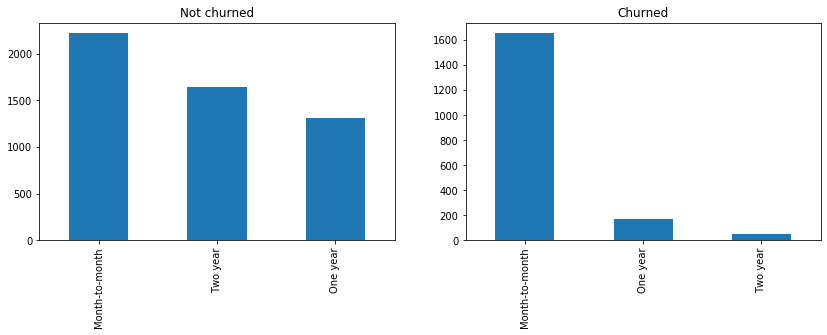

In [8]:
feature = "Contract"
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
contractchurn = df[df.Churn == "No"][feature].value_counts().plot("bar", ax=ax[0]).set_title("Not churned")
contractchurn = df[df.Churn == "Yes"][feature].value_counts().plot("bar", ax=ax[1]).set_title("Churned")

Here we can see that for customers are more likely to churn if they have month-to-month contracts, which makes sense. 